In [1]:
import sympy as sp
import jax.numpy as np
from jax import vmap
import matplotlib.pyplot as plt

In [2]:
from eq1 import config
from main import run

In [3]:
network, best = run(config)

21:56:07.250 [INFO] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
21:56:07.260 [INFO] Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
21:56:07.280 [INFO] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
21:56:07.322 [INFO] Constructed symbolic model
21:56:07.562 [INFO] Constructed loss equation
21:56:07.820 [INFO] Constructed JAXified model
21:56:10.404 [INFO] Epoch: 1, Loss: 18.06186294555664
21:56:10.458 [INFO] Epoch: 2, Loss: 6.456302165985107
21:56:10.506 [INFO] Epoch: 3, Loss: 16.912567138671875
21:56:10.551 [INFO] Epoch: 4, Loss: 6.093877792358398
21:56:10.602 [INFO] Epoch: 5, Loss: 2.367640733718872
21:56:10.643 [INFO] Epoch: 6, Loss: 1.198925495147705
21:56:10.688 [INFO] Epoch: 7, Loss: 0.6371877193450928
21:56:10.729 [INFO] Epoch: 8, Loss: 1.1922056674957275
21:56:10.774 [INFO] Epoch: 9, 

Nothing more to prune!


$\displaystyle 0.392628759145737 k x + 0.598986446857452 e^{1.17462992668152 k x} + 0.396474972367287$

In [4]:
network.model_y

a_o1__02__03 + a_o4__00__03*k*x + a_o5__01__03*exp(a_o4__00__01*k*x) + b

In [5]:
y_prediction_best = best.model_y.subs(zip(best.alphas, best.W))
y_prediction_best

0.392628759145737*k*x + 0.598986446857452*exp(1.17462992668152*k*x) + 0.396474972367287

# Plot

In [6]:
k = network.symbols.k
x = network.symbols.x

In [7]:
y_pred_fn = sp.lambdify([k, x], y_prediction_best)
y_real_fn = sp.lambdify([k, x], sp.exp(k*x))

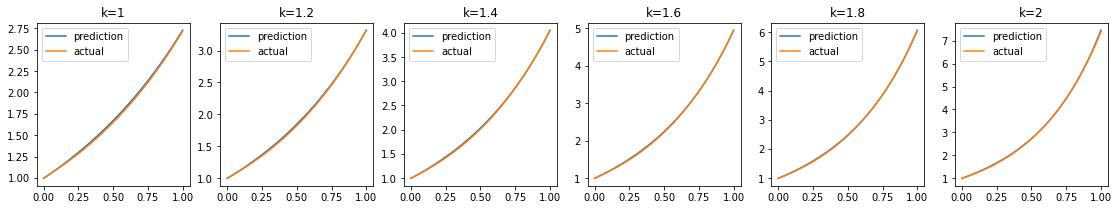

In [8]:
x_try = np.linspace(0, 1, 50)

k_tries = [1, 1.2, 1.4, 1.6, 1.8, 2]
fig, axs = plt.subplots(1, len(k_tries))
fig.set_size_inches(len(k_tries)*3.2, 3)

for ax, k_try in zip(axs, k_tries):
  ax.set_title(f'k={k_try}')
  ax.plot(x_try, y_pred_fn(k_try, x_try), label=f'prediction')
  ax.plot(x_try, y_real_fn(k_try, x_try), label=f'actual')
  ax.legend()
plt.show()

# Test

In [9]:
dydx = sp.diff(y_prediction_best, 'x')
dydx

loss = (dydx - network.symbols.k * y_prediction_best)**2

sp.integrate(loss, ('x', 0, 1), ('k', 1.4, 1.6))

0.000951200647475420

In [10]:
y = sp.exp(k*x)

dydx = sp.diff(y, x)

loss = (dydx - k * y)**2

sp.integrate(loss, ('x', 0, 1), ('k', 1.4, 1.6))

0